# Automarken aufgrund von Bildern erkennen

In [64]:
import os, shutil, glob, re
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Convolution2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics as sk_metrics
import itertools
import matplotlib.pyplot as plt
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [65]:
# lokaler pfad
train_path = 'C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/Datensatz/train'
valid_path = 'C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/Datensatz/valid'
test_path =  'C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/Datensatz/test'

In [38]:
# lokaler Beispiel pfad
train_path = 'C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/old_test/train'
valid_path = 'C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/old_test/valid'
test_path =  'C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/old_test/test'

In [66]:
all_subdirs = os.listdir(train_path)
len(all_subdirs)

42

# Bilddaten pre-processen und anzeigen

In [67]:
# Load dataset for display
para_kwargs = dict(
    labels='inferred', 
    label_mode='int',   # for fitting = 'categorical' for print = 'int'
    color_mode='rgb', 
    batch_size=32, 
    image_size=(112, 112))

train_ds = keras.preprocessing.image_dataset_from_directory(train_path, **para_kwargs, seed=1)
valid_ds = keras.preprocessing.image_dataset_from_directory(valid_path, **para_kwargs, seed=1)
test_ds = keras.preprocessing.image_dataset_from_directory(test_path, **para_kwargs, seed=1)

Found 38580 files belonging to 42 classes.
Found 12860 files belonging to 42 classes.
Found 12860 files belonging to 42 classes.


In [68]:
class_names = train_ds.class_names
print(class_names)

['Acura', 'Alfa Romeo', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'FIAT', 'Ferrari', 'Ford', 'GMC', 'Genesis', 'Honda', 'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'MINI', 'Maserati', 'Mazda', 'McLaren', 'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Porsche', 'Ram', 'Rolls-Royce', 'Subaru', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'smart']


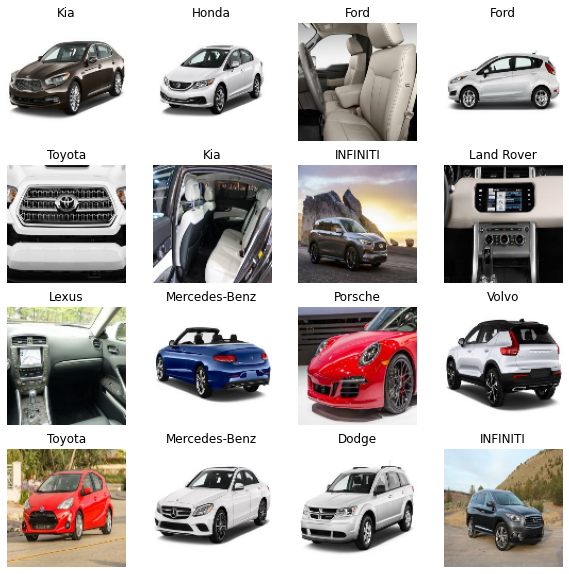

In [69]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [70]:
# Load dataset again now for fitting (different label mode)
para_kwargs = dict(
    labels='inferred', 
    label_mode='categorical',   # for fitting = 'categorical' for print = 'int'
    color_mode='rgb', 
    batch_size=64, 
    image_size=(112, 112))

train_ds = keras.preprocessing.image_dataset_from_directory(train_path, **para_kwargs, seed=1)
valid_ds = keras.preprocessing.image_dataset_from_directory(valid_path, **para_kwargs, seed=1)
test_ds = keras.preprocessing.image_dataset_from_directory(test_path, **para_kwargs, seed=1)

Found 38580 files belonging to 42 classes.
Found 12860 files belonging to 42 classes.
Found 12860 files belonging to 42 classes.


In [71]:
# Standardize data
from tensorflow.keras import layers
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Create Model

In [72]:
# Define hyperparameter of the CNN
input_shape = (112, 112, 3)
# batch_size = 32
nb_classes = len(class_names)
kernel_size = (3, 3)
pool_size = (2, 2)

In [77]:
# create own Model
# define CNN with 2 convolution blocks and 2 fully connected layers
# includes 1 MaxPooling layers and 1 Dropout layer
model = Sequential()

model.add(Convolution2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(32, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(32, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(32, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# summarize model along with number of model weights
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 112, 112, 8)       224       
_________________________________________________________________
activation_22 (Activation)   (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 8)       584       
_________________________________________________________________
activation_23 (Activation)   (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 16)      1168      
_________________________________________________________________
activation_24 (Activation)   (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 32)     

In [46]:
# Alternative: Pre-trained Model auswählen (aus TF-Hub)
model_name = "mobilenet_v2_100_224"
model_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4" 
IMAGE_SIZE = (224, 224, 3)
BATCH_SIZE = 32
print(f"\nAusgewaehltes model: {model_name} : {model_handle}")
print(f"\nBild-Groesse {IMAGE_SIZE}")

# CNN zusammenstellen mit Anzahl Klassen wie im Datenset 
print("\nModell erstellen mit", model_handle)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE)),
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names), 
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE)
model.summary()



Ausgewaehltes model: mobilenet_v2_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4

Bild-Groesse (224, 224, 3)

Modell erstellen mit https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4


OSError: SavedModel file does not exist at: C:\Users\alex\AppData\Local\Temp\tfhub_modules\cb6f9b5c866e6537fad904ca1ed532322ee8d524/{saved_model.pbtxt|saved_model.pb}

# Train Model

In [11]:
# Create a callback that saves the model's weights
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
# train the model
history=model.fit(train_ds
                  , epochs=15
                  , verbose=1
                  , validation_data=(valid_ds)
#                  , callbacks=[cp_callback]    # Pass callback to training
                 )  

Epoch 1/15
 91/603 [===>..........................] - ETA: 31:54 - loss: 3.6589 - accuracy: 0.0416

In [13]:
# Save the model
model.save('C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/saved_model')

INFO:tensorflow:Assets written to: C:/Users/alex/CAS_ML_local/B_Deeplearning/03_Project/saved_model\assets


# Evaluate Model

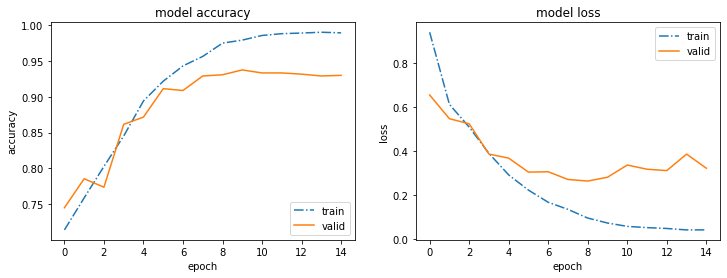

In [46]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

# Prediction with Testdata

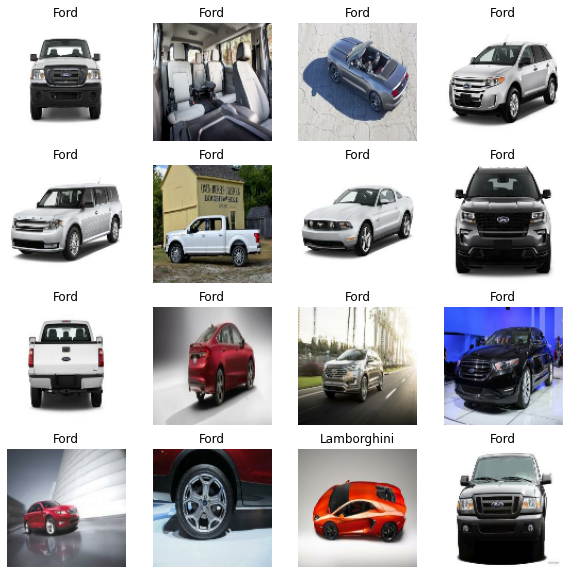

In [31]:
image_batch, label_batch = next(iter(test_ds))

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [47]:
# Predict Brands on Test Data
pred=model.predict(test_ds)
y_pred = np.argmax(pred, axis=1)
y_pred

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [50]:
y_true = np.concatenate([y_true for x, y_true in test_ds], axis=0)
y_true

array([2, 2, 2, ..., 2, 2, 2])

In [51]:
print(all_subdirs)
print(confusion_matrix(y_true, y_pred))

['Acura', 'Ferrari', 'Ford', 'Lamborghini']
[[ 49   2 178   5]
 [  3   0  13   2]
 [170   6 671  35]
 [ 13   0  35   2]]


(-0.5, 111.5, 111.5, -0.5)

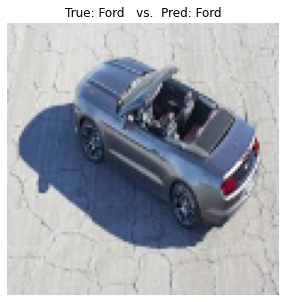

In [63]:
image_number = 2
plt.figure(figsize=(5, 5))
plt.imshow(image_batch[image_number].numpy().astype("uint8"))
true_label = label_batch[image_number]
pred_label = y_pred[image_number]
plt.title('True: ' + class_names[true_label] + '   vs.  Pred: ' + class_names[pred_label])
plt.axis("off")

In [61]:
target_names = class_names
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Acura       0.21      0.21      0.21       234
     Ferrari       0.00      0.00      0.00        18
        Ford       0.75      0.76      0.75       882
 Lamborghini       0.05      0.04      0.04        50

    accuracy                           0.61      1184
   macro avg       0.25      0.25      0.25      1184
weighted avg       0.60      0.61      0.61      1184

